In [1]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import kagglehub
import cv2

from tensorflow import keras
# Visualization
import matplotlib.pyplot as plt

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.optimizers import Adam

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Accuracy
from sklearn.metrics import accuracy_score

In [2]:
#Download data set and get the path
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path);

Path to dataset files: /Users/turkan/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [3]:
train_dir = path + "/Training"
test_dir = path + "/Testing"
#train_dataset = train_dir.flow_from_directory(train_dir, target_size=(250,250))
#test_dataset = test_dir.flow_from_directory(test_dir, target_size=(250,250))

In [4]:
cv2.imread(path + "/Training/glioma/Tr-glTr_0000.jpg").shape

(512, 512, 3)

In [5]:
img = load_img(path + "/Training/glioma/Tr-glTr_0000.jpg")

In [6]:
#for getting class indices
datagen = ImageDataGenerator(rescale=1./255)

train_dataset = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)
test_dataset = datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)
print(train_dataset.class_indices)
print(train_dataset.classes)
print(test_dataset.class_indices)
print(test_dataset.classes)

Found 5704 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
[0 0 0 ... 3 3 3]
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
[0 0 0 ... 3 3 3]


In [7]:
# Augmented Data Generator (with augmentation)
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_train_dataset = augmented_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

augmented_test_dataset = augmented_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

print(augmented_train_dataset.class_indices)
print(augmented_train_dataset.classes)
print(augmented_test_dataset.class_indices)
print(augmented_test_dataset.classes)

Found 5704 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
[0 0 0 ... 3 3 3]
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
[0 0 0 ... 3 3 3]


In [8]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [9]:
#utilizing cnn with maxpooling, and all the layers are given in a form of list, one by one we provide the layers, 
# so Conv2D(how many filters you want to keep inside this layer which is how many features to learn from, 
# (size of the filters), activation function, input_shape=(256, 256, 3-->dimension because rgb) )
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
                                    #then adding a max pooling layer
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    #4 because 4 classes
                                    #softmax because we have multiple classes and not binary
                                    tf.keras.layers.Dense(4, activation='softmax')])
model.summary()

/Users/turkan/Desktop/VU/ML/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,454,660 (13.18 MB)

 Trainable params: 3,454,660 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(loss='categorical_crossentropy', 
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [11]:
model_fit = model.fit(train_dataset,
          epochs=15,
          validation_data=test_dataset,
          callbacks=[callback]) 

Epoch 1/15


/Users/turkan/Desktop/VU/ML/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 32s 173ms/step - accuracy: 0.6015 - loss: 0.9034 - val_accuracy: 0.7727 - val_loss: 0.5289
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 31s 171ms/step - accuracy: 0.8630 - loss: 0.3835 - val_accuracy: 0.8246 - val_loss: 0.4278
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 32s 177ms/step - accuracy: 0.9205 - loss: 0.2326 - val_accuracy: 0.8955 - val_loss: 0.2561
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 31s 171ms/step - accuracy: 0.9413 - loss: 0.1523 - val_accuracy: 0.9024 - val_loss: 0.2591
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 30s 169ms/step - accuracy: 0.9559 - loss: 0.1148 - val_accuracy: 0.9397 - val_loss: 0.1728
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 31s 173ms/step - accuracy: 0.9735 - loss: 0.0749 - val_accuracy: 0.9420 - val_loss: 0.1726
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 31s 171ms/step - accuracy: 0.9782 - loss: 0.0538 - val_accuracy: 0.9580 - val_loss: 0.1467
Epoch 8/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 31s 171ms/step - accuracy: 0.9884 - loss: 0.0329 - val

In [12]:
# Train the model on the augmented dataset
augmented_model_fit = model.fit(
    augmented_train_dataset,
    epochs=15,
    validation_data=augmented_test_dataset,
    callbacks=[callback]
)

Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 35s 194ms/step - accuracy: 0.6021 - loss: 1.1531 - val_accuracy: 0.7353 - val_loss: 0.6907
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 187ms/step - accuracy: 0.7709 - loss: 0.5840 - val_accuracy: 0.7971 - val_loss: 0.5273
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 189ms/step - accuracy: 0.8364 - loss: 0.4406 - val_accuracy: 0.8299 - val_loss: 0.4173
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 190ms/step - accuracy: 0.8600 - loss: 0.3862 - val_accuracy: 0.8490 - val_loss: 0.3815
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 192ms/step - accuracy: 0.8806 - loss: 0.3285 - val_accuracy: 0.8589 - val_loss: 0.3760
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 191ms/step - accuracy: 0.8982 - loss: 0.2919 - val_accuracy: 0.8711 - val_loss: 0.3728
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 190ms/step - accuracy: 0.8883 - loss: 0.2970 - val_accuracy: 0.8757 - val_loss: 0.3141
Epoch 8/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 190ms/step - accuracy: 0.8970 - loss: 0

In [13]:
# Get predictions for test dataset
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = test_dataset.classes
class_labels = list(test_dataset.class_indices.keys())

class_accuracies = {}
for class_id, class_name in enumerate(class_labels):
    class_mask = (y_true == class_id)
    class_accuracy = accuracy_score(y_true[class_mask], y_pred[class_mask])
    class_accuracies[class_name] = class_accuracy

# Print results
for class_name, accuracy in class_accuracies.items():
    print(f"Accuracy for class {class_name}: {accuracy:.2%}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
Accuracy for class glioma: 18.33%
Accuracy for class meningioma: 16.67%
Accuracy for class notumor: 36.05%
Accuracy for class pituitary: 19.33%


In [14]:
# Get predictions for the augmented test dataset
y_pred_probs_augmented = model.predict(augmented_test_dataset)
y_pred_augmented = np.argmax(y_pred_probs_augmented, axis=1)

y_true_augmented = augmented_test_dataset.classes
class_labels_augmented = list(augmented_test_dataset.class_indices.keys())

class_accuracies_augmented = {}
for class_id, class_name in enumerate(class_labels_augmented):
    class_mask_augmented = (y_true_augmented == class_id)
    class_accuracy_augmented = accuracy_score(y_true_augmented[class_mask_augmented], y_pred_augmented[class_mask_augmented])
    class_accuracies_augmented[class_name] = class_accuracy_augmented

for class_name, accuracy in class_accuracies_augmented.items():
    print(f"Accuracy for class {class_name} on augmented test data: {accuracy:.2%}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step
Accuracy for class glioma on augmented test data: 23.67%
Accuracy for class meningioma on augmented test data: 17.97%
Accuracy for class notumor on augmented test data: 29.38%
Accuracy for class pituitary on augmented test data: 25.00%


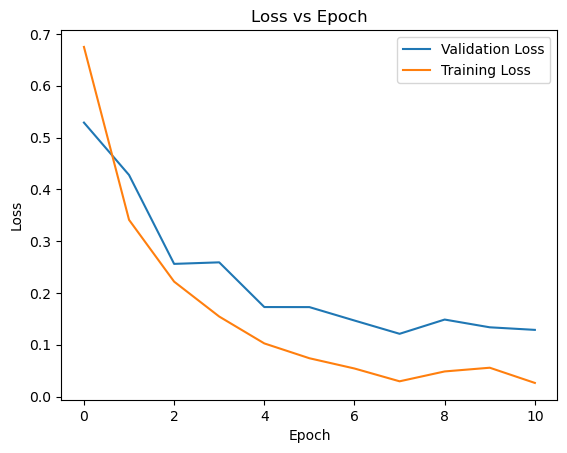

In [15]:
plt.plot(model_fit.history['val_loss'], label='Validation Loss')
plt.plot(model_fit.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.savefig("epoch-loss.png")
plt.show()

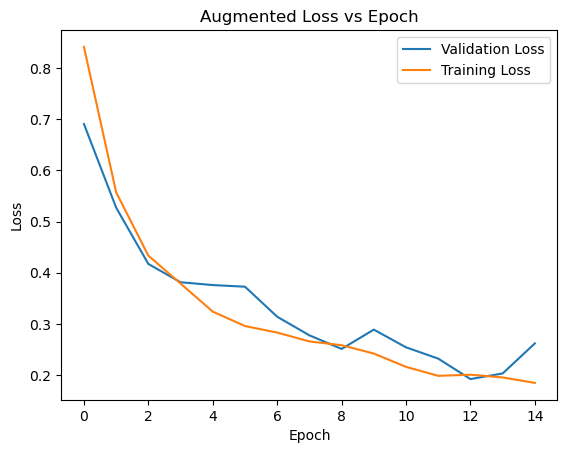

In [17]:
plt.plot(augmented_model_fit.history['val_loss'], label='Validation Loss')
plt.plot(augmented_model_fit.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Augmented Loss vs Epoch')
plt.legend()
plt.savefig("epoch-loss-augmented.png")
plt.show()